In this notebook, we follow Andrej Karpathy's brilliant tutorial (https://www.youtube.com/watch?v=VMj-3S1tku0) on building a simple automatic differentiation engine for scalar valued variables.

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
# first we build a data structure to keep track of operations
class Value:

  def __init__(self, data, _children=(), _op='',label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None 
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data}, label={self.label})"

  def __neg__(self): #-self
    return self * -1

  def __add__(self, other): #order: self + other
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data, (self, other), _op='+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other): #order: other + self
    return self + other

  def __sub__(self, other): #order: self - other
    return self + (-other)

  def __mul__(self, other): #order: self * other
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data * other.data, (self, other), _op='*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  
  def __pow__(self,deg):
    #assuming other is a constant and not a variable
    assert(isinstance(deg, (int, float)), "only supports powers that are int or float")
    out = Value(self.data ** deg, (self,), _op=f'**{str(deg)}')
    def _backward():
      self.grad += deg * self.data ** (deg-1)  * out.grad
    out._backward = _backward
    return out

  def __truediv__(self, other): #order: self / other
    return self * other**-1

  def __rmul__(self,other): # order: other * self (reversed order)
    return self*other

  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n)+1)
    out = Value(t, (self,), _op='tanh')
    def _backward():
      self.grad += (1-t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    t = math.exp(x)
    out = Value(t, (self,), _op='exp')
    def _backward():
      self.grad += t * out.grad
    out._backward = _backward
    return out

  def backward(self):
    # build topological order
    topo=[]
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev: # all children are added recursively to topo before the parent (v)
          build_topo(child)
        topo.append(v) #append parent after all children
    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

<>:44: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:44: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:44: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-83-ee69283a1e69>:44: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(isinstance(deg, (int, float)), "only supports powers that are int or float")


In [ ]:
# visualization
from graphviz import Digraph

def trace(root): #builds a graph from a Value object
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root): #visualizes graph from value object
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))

    dot.node(name = uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
    if n._op:
      dot.node(name=uid+n._op, label = n._op)
      dot.edge(uid + n._op, uid)
  for n1,n2 in edges:
    dot.edge(str(id(n1)), str(id(n2))+n2._op)
  
  return dot

## In the following, we explore a bunch of toy examples as we build out the Value class capabilities.

In [ ]:
#toy example

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d =  e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

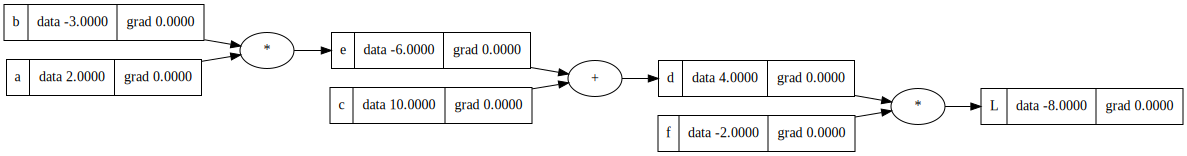

In [ ]:
g = draw_dot(L)
g

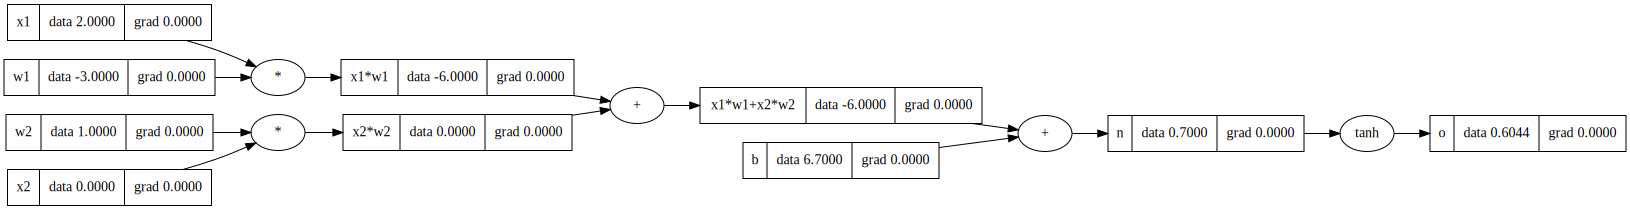

In [ ]:
#another example -- a single neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.7, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1' 
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1+x2*w2'
n = x1w1x2w2+b; n.label='n'
o = n.tanh(); o.label='o'
draw_dot(o)

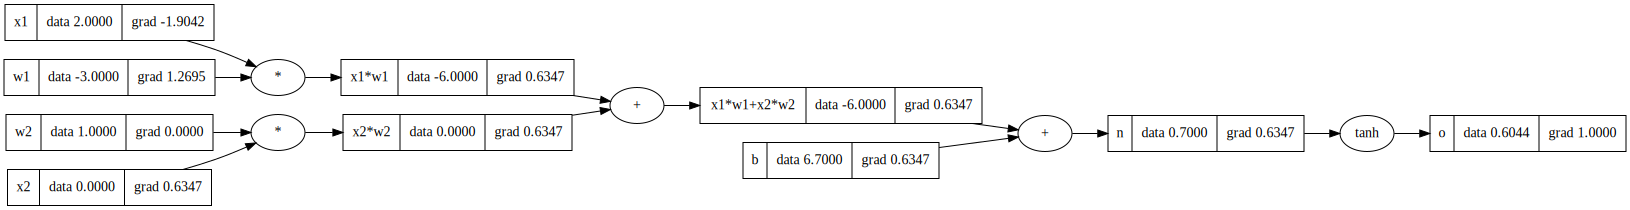

In [ ]:
o.backward()
draw_dot(o)

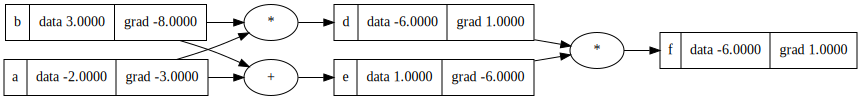

In [ ]:
#another test example

a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label='d'
e = a + b ; e.label='e'
f = d * e ; f.label='f'

f.backward()

draw_dot(f)

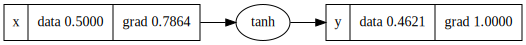

In [ ]:
#tanh and exp example

x = Value(0.5, label='x')

#direct
y = x.tanh() ; y.label='y'
y.backward()
draw_dot(y)

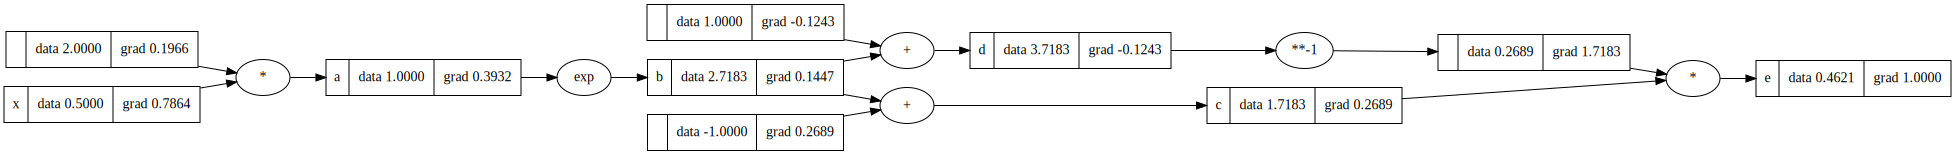

In [ ]:
#reinit (otherwise the gradients of x are not zero b/c of previous code cell)
x = Value(0.5, label='x')

#indirect
a = 2*x     ; a.label = 'a'
b = a.exp() ; b.label = 'b'
c = b-1     ; c.label = 'c'
d = b+1     ; d.label = 'd'
e = c/d     ; e.label = 'e' 
e.backward()
draw_dot(e)

Everything matches! And by everything, of course I mean the output and the derivative with respect to the input $x$. As additional verification, we can backpropogate by hand, and we arrive at the same results. Now let's use the above micrograd engine to build a simple multilayer perceptron.

In [112]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(np.random.uniform(-1,1)) for i in range(nin)]
    self.b = Value(np.random.uniform(-1,1))

  def __call__(self,x):
    #w*x+b
    act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b] 

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for i in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

  def parameters(self):
     return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts #prepends nin to list of nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers: #forward pass through the MLP
      x=layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [113]:
x = [2.0,3.0, -1.0]
n = MLP(3, [4,4,1])
y = n(x)

In [ ]:
#draw_dot(y)

In [114]:
#example dataset from the lecture

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] #desired targets

#before training
ypred = [n(x) for x in xs]
print(ypred)

[Value(data=0.5319682250149593, label=), Value(data=0.7589117693968087, label=), Value(data=0.7926820829330167, label=), Value(data=0.6442006375480694, label=)]


In [134]:
for k in range(100):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred))

  #backward pass
  for p in n.parameters(): #recall gradients accumulate in the backward pass, so we need to zero out things beforehand
    p.grad = 0.0
  loss.backward()

  #update
  for p in n.parameters(): 
    p.data += -0.1 * p.grad

  print(f'step {k} | loss: {loss.data}')

step 0 | loss: 0.002261011090757827
step 1 | loss: 0.00224116431715543
step 2 | loss: 0.0022216549519994766
step 3 | loss: 0.002202474545830872
step 4 | loss: 0.0021836149275073474
step 5 | loss: 0.002165068192874548
step 6 | loss: 0.0021468266939848007
step 7 | loss: 0.002128883028832923
step 8 | loss: 0.002111230031580707
step 9 | loss: 0.0020938607632428772
step 10 | loss: 0.0020767685028094513
step 11 | loss: 0.002059946738780962
step 12 | loss: 0.0020433891610942144
step 13 | loss: 0.0020270896534177758
step 14 | loss: 0.002011042285797608
step 15 | loss: 0.001995241307634671
step 16 | loss: 0.001979681140976677
step 17 | loss: 0.0019643563741083463
step 18 | loss: 0.0019492617554242955
step 19 | loss: 0.001934392187570431
step 20 | loss: 0.0019197427218402476
step 21 | loss: 0.0019053085528129175
step 22 | loss: 0.001891085013221589
step 23 | loss: 0.0018770675690398739
step 24 | loss: 0.0018632518147763768
step 25 | loss: 0.0018496334689666722
step 26 | loss: 0.00183620836985322

In [135]:
ypred

[Value(data=0.9887484165152389, label=),
 Value(data=-0.984994907729048, label=),
 Value(data=-0.9790361152834683, label=),
 Value(data=0.9798799808567508, label=)]

In [118]:
#draw_dot(loss)